# Data Mining - MSDS 7331 - Wednesday 6:30, Summer 2016
Team B: Chandan Nahar, Bryan Hudson, Mike Sylvester
Lab 3

## Business Understanding:

The goal of this project is to build a custom recommendation system. This system is intended to be used as a tool for employers to better target potential employees. The recommendation system uses 2013 data from American Community Survey (ACS). From this data a recommendation is provided for what type of college degree better suits a particular industry. This type of tool is very valuable to businesses since it could potentially lead to better hiring decisions. For instance, it would lead to fewer turnovers, happier employees, and increased productivity.  

## Data Understanding: 
American Community Survey (ACS) 2013 Public Use Microdata Sample (PUMS) files, collected by U.S. Census Bureau, consists of responses provided to ACS by participants.  Survey is conducted on a sample of roughly 1% of total U.S. poulation per year. Responses to each survey question are classified into categories which remain mostly consistent year over year. Two PUMS CSV files were provided for 2013, each containing about half the states. Data dictionary and usage documentation is also provided by U.S. Census Bureau.  

For this analysis, CSV files were imported into MS SQL 2016 for data exploration and analysis. 

** Dataset description: **

Total record count in dataset: 3,132,795    
Total field count: 283 (80 of which are calculated weights)    


** Variables used (and description): **  
- SerialNo: unique household; 1,359,520 distinct integer values  
- SPOrder: unique individual within household (1-20 integer value); 3132795 distinct individuals  
- ST: US state or territory where household resides at time of survey, 51 two letter alpha abbreviations  
- AgeP: age of unique individual, integer values ranging from 0 to 95  
- Sch: person is currenly enrolled in school; blank means person is less than 3 years old  
- INDP: industry in which person is currently employed as classified by survey, blank if less than 16 years old or has not worked in last 5 years.  industries are further classified into 18 groups  
- FOD1P: first college degree held by person, as classified by survey, blank if no degree  
- HINS1: binary classification for insurance provided by current or former employer or union  
- JWMNP: travel time to work in minutes (integer from 1 to 200); blank signifies either not working or working from home  
- WKHP: normal number of hours worked per week during previous year, integer from 1 to 99  
- PINCP: person's total income in U.S. dollars, numeric values from -13600 to 1281000

** Overall condition: **
- Dataset is very clean and extremely well defined by data dictionary   
- No values are missing; blanks are assigned as classification value in data dictionary   
- Each row represents one unique individual; no duplicate rows  
- Outliers left in dataset. Observed outliers include 7249 persons reporting working more than 80 hrs per week, 19643 person commuting more than 120 minutes, 3643 persons earning over 500,000 dollars previous year  
- No mistakes were observed in the dataset 

** Mean values: for selection criteria - working adults not enrolled in school with degree ** 
- Mean age: 47 years old  
- Mean commute: 21 minutes  
- Mean income: $76,668  

** Summary statistics: ** 
- Minors: 673613 (21.5%)
- Adults in school: 251454 (8%)
- Adults not in school and not working: 597052 (19.1%)
- Adults not in school but working without degree: 1082356 (34.5%)
- Total meeting criteria: 528320 (16.9%)

## Data Preparation:

** SQL table/selection: ** 
- Each CSV imported into MS SQL 2016 as a separate table.  
- Clustered index created on each table for SerialNo and SPOrder to identify each unique individual.  
- View created to union total data from both tables into one source.    
- 500,000 rows (persons) selected randomly using NewID() where selection criteria is met.  
- 500k rows is roughly 15% of total data and close to 95% of total rows meeting criteria and was the target data size prior to selection criteria being applied.  

SQL Selection Criteria:  
where [AGEP] >=18  
	and [SCH] = 1  
	and [INDP] is not null or blank  
	and [FOD1P] is not null or blank  
	and [PINCP] is not null  

## Custom Scoring (ranking)

A custom scoring system was developed to improved the accuracy of the recommendation system. The original model was based only on salary resulted in low accuracy. The custom model significantly improved the overall accuracy by creating a scalar value for
the score metric.

- Score is a measure of job happiness calculated from the combination of four possible measures.  
- Several iterations of score totals were used before arriving at current version which yielded the best root mean square error.    
- Each of the four values is based on a stratification of a value included in the data set.   
- Working theory is that salary is the most important factorin job satisfaction and can be awarded the most points.   - Aditional points are awarded for health insurance being provided by employer, short commute and average work week less than 45 hours.  
- Penalty points given for longer commutes and working hours per week.  

** SQL Pseudo Code used for the customer scoring variable: ** 

INSSCORE = when [HINS1] = 1 then 2 else 0 (one point for insurance provided by employer, no penalty if not)  
COMMScore = when [JWMNP] is null or '' then 2 (two points for no commute)  
		when [JWMNP] <= 15 then 1 (one point if commute 15 minutes or less)  
		when [JWMNP] between 16 and 30 then 0 (no points for commute 15-30 minutes)  
		when [JWMNP] between 31 and 45 then -1 (one point penalty for 30-45 minute commute)  
		when [JWMNP] between 45 and 60 then -2 (two point penalty for 45-60 minute commute)  
		when [JWMNP] > 60 then -3 (three point prenalty for commute more than one hour)  
WKHRSScore = when [WKHP] is null or '' then 0 (no points or penalty is for not reporting any hours worked)  
		when [WKHP] < 45 then 1 (one point for working less than 45 hours per week)  
		when [WKHP] between 45 and 50 then -1 (one point penalty for working 45-50 hours per week)  
		when [WKHP] between 50 and 55 then -2 (two point penalty for working 50-55 hours per week)  
		when [WKHP] between 55 and 60 then -3 (three point penalty for working 55-60 hours per week)  
		when [WKHP] >=60 then -4 (four point penalty for working more than 60 hours per week)  
PINCP = when [PINCP] < 20000 then 0 (no points for earning less than 20k per year)  
		when [PINCP] between 20000 and 35000 then 1 (one point for 20-35k per year)  
		when [PINCP] between 35000 and 50000 then 2 (two points for 35-50k per year)  
		when [PINCP] between 50000 and 75000 then 3 (three points for 50-75k per year)  
		when [PINCP] between 75000 and 90000 then 4 (four points for 75-90k per year)  
		when [PINCP] between 90000 and 115000 then 5 (five points for 90-115k per year)  
		when [PINCP] between 115000 and 130000 then 6 (six points for 115-130k per year)  
		when [PINCP] between 130000 and 150000 then 7 (seven points for 130-150k per year)  
		when [PINCP] between 150000 and 175000 then 8 (eight points for 150-175k per year)  
		when [PINCP] >= 175000 then 9 (nine points for 175k or more per year)  
EMPScore = PINCP+INSSCORE+COMMScore+WKHRSScore (total of four measures calculated as score value)  
        

## Data Input:

In [13]:
from graphlab import SFrame 
import graphlab as gl

In [14]:
#Read the data into a graph lab SFrame
pus = gl.SFrame.read_csv('C:\Users\Mike Sylvester\Box Sync\DataMining_Lab\FinalLab\ss13pusc_500ks.csv', 
                          column_type_hints={"EMPScore":int})

Finished parsing file C:\Users\Mike Sylvester\Box Sync\DataMining_Lab\FinalLab\ss13pusc_500ks.csv

Parsing completed. Parsed 100 lines in 0.241212 secs.

Finished parsing file C:\Users\Mike Sylvester\Box Sync\DataMining_Lab\FinalLab\ss13pusc_500ks.csv

Parsing completed. Parsed 500000 lines in 0.291603 secs.

## Data Visualizations:  

The below boxplot shows score distribution by industry. The distribution looks evenly spread and there no obvious
outliers.

In [15]:
# Graph Lab box plot of employees score and industry
gl.canvas.set_target('ipynb')
pus.show(view="BoxWhisker Plot", x="INDP", y="EMPScore")

# Visualization Description:
Visualization generated using Tableau 9.3. Summary counts for each variable exported from SQL into Excel, then Excel used as a data source for Tableau.  
- Age bar graph groups the total survey population into nine categories.  All minors (under 18) are grouped together.
- Income bar graph shows the total population meeting the selection criteria only and uses the same classification as the scoring metric with the exception of negative and zero reported income being broken out from the under $20,000 group.
- Degree packed bubble graph show the relative size of the various degrees in the criteria population.
- Industry packed bubble graph illustrates the relative size of the industry parent groupings, as defined by U.S. Census Bureau, for the criteria population.
- Work Hours bar graph shows the count of distribution of persons from the criteria population in the same groupings as the scoring.

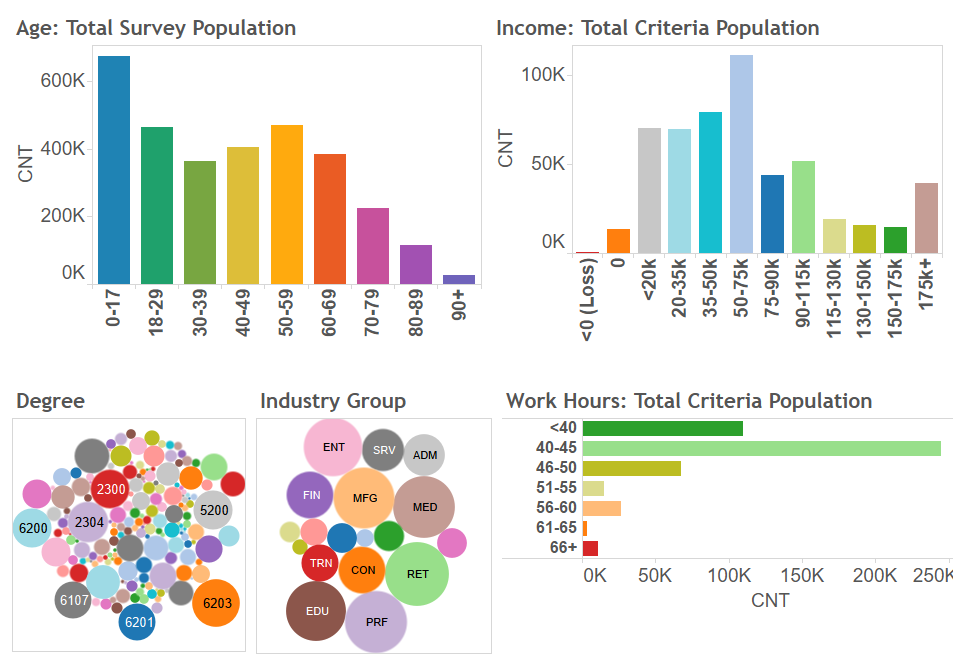

In [16]:
from IPython.display import Image
Image(filename="C:\Users\Mike Sylvester\Box Sync\DataMining_Lab\FinalLab\PUMS.png")

## Model Creation:

** Description of calculations to be performed: **   
- Models will be evaluated based on Root Mean Square Error rates.  
- RMSE heavily penalizes estimates that are quite different in range and are typically used for recommendation engines where the prediction value is scalar, as our score is. 

** Two models will be created to determine which results in better accuracy: **  
- Default model using just the income classification for the score
- Using custom generated score

** First Model Evaluation: **   
Default model using just the income classification for the score.  RMSE of 2.48 is high which
shows that there is a lot of variability within each industry, as would be expected.

In [17]:
model = gl.recommender.create(pus, user_id="INDP", item_id="FOD1P", target="PINCP")
results = model.recommend(users=None, k=10)
model.save("my_model")
results.head() 

Recsys training: model = ranking_factorization_recommender

Preparing data set.

Data has 500000 observations with 267 users and 173 items.

Data prepared in: 0.679038s

Training ranking_factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 32       |

| regularization                 | L2 Regularization on Factors                     | 1e-009   |

| solver                         | Solver used for training                         | adagrad  |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-009   |

| ranking_regularization         | Rank-based Regularization Weight                 | 0.25     |

| max_iterations                 | Maximum Number of Iterations                     | 25       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 62500 / 500000 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 4.54545           | Not Viable                               |

| 1       | 1.13636           | Not Viable                               |

| 2       | 0.284091          | Not Viable                               |

| 3       | 0.0710227         | Not Viable                               |

| 4       | 0.0177557         | Not Viable                               |

| 5       | 0.00443892        | Not Viable                               |

| 6       | 0.00110973        | No Decrease (18.1558 >= 12.9301)         |

| 7       | 0.000277433       | 12.0779                                  |

| 8       | 0.000138716       | 12.4416                                  |

| 9       | 6.93581e-005      | 12.6853                                  |

| 10      | 3.46791e-005      | 12.8014                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.000277433       | 12.0779                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 0us          | 12.9599           | 2.5711                |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 748.043ms    | 6.08279           | 2.42049               | 0.000277433 |

| 2       | 1.70s        | 5.58496           | 2.31559               | 0.000277433 |

| 3       | 2.50s        | 5.4787            | 2.29262               | 0.000277433 |

| 4       | 3.47s        | 5.74003           | 2.34832               | 0.000277433 |

| 5       | 4.49s        | 6.32192           | 2.46794               | 0.000277433 |

| 6       | 5.56s        | 7.23458           | 2.64476               | 0.000277433 |

| 10      | 8.87s        | 12.689            | 3.52224               | 0.000277433 |

| 11      | 9.61s        | 14.3632           | 3.7506                | 0.000277433 |

| 15      | 12.80s       | 21.9582           | 4.64744               | 0.000277433 |

| 16      | 13.99s       | DIVERGED          | DIVERGED              | 0.000277433 |

| RESET   | 14.43s       | 12.9585           | 2.57083               |             |

| 4       | 17.45s       | 6.02084           | 2.4079                | 0.000138716 |

| 9       | 21.37s       | 6.56581           | 2.5172                | 0.000138716 |

| 14      | 25.20s       | 8.17584           | 2.81647               | 0.000138716 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached (hard limit).

Computing final objective value and training RMSE.

Final objective value: 15.0768

Final training RMSE: 2.85421

INDP,FOD1P,score,rank
7860,3801,2.99764129515,1
7390,3801,3.15254562473,1
7390,3201,3.15125286701,2
7070,2404,3.12367421028,1
7070,2416,3.12307420378,2
7070,5008,3.12286397843,3
7070,5005,3.12187266509,4
7070,1104,3.12171845355,5
7070,6202,3.12046104361,6
7070,5001,3.12000974513,7


** Second Model Evaluation: ** 

Using generated score instead of straight income classification group and cosine similarity type, recommended  
score values have increased from 3.0 to 9.0.  This is a major improvement. 

2100 = COMPUTER AND INFORMATION SYSTEMS  
similar : 2300 = GENERAL EDUCATION  
          2414 = MECHANICAL ENGINEERING  
          3600 = BIOLOGY  
          
Interpretation:   Overlap between education of CIS students and ME students is expected, but general education and biology are not.  

In [18]:
item_item = gl.recommender.item_similarity_recommender.create(pus, 
                                  user_id="INDP", 
                                  item_id="FOD1P", 
                                  target="EMPScore",
                                  only_top_k=5,
                                  similarity_type="cosine")

results = item_item.get_similar_items(k=3)
results.head()

Recsys training: model = item_similarity

Warning: Ignoring columns SERIALNO, SPORDER, ST, AGEP, SCH, INSSCORE, COMMScore, WKHRSScore, PINCP;

To use these columns in scoring predictions, use a model that allows the use of additional features.

Preparing data set.

Data has 500000 observations with 267 users and 173 items.

Data prepared in: 0.234013s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 33.002ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 56.004ms                            | 0.5              | 0               |

| 67.004ms                            | 100              | 173             |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.117007s

FOD1P,similar,score,rank
2100,2300,0.918719768524,1
2100,2414,0.911089539528,2
2100,3600,0.898786962032,3
2399,2300,0.934213399887,1
2399,2414,0.894515097141,2
2399,4901,0.88225954771,3
1902,2300,0.954706668854,1
1902,2304,0.949998795986,2
1902,2414,0.9391233325,3
6107,2304,0.910179853439,1


## Test and train selected model - Item Similarity
The custom scoring model was selected due to the higher accuracy and will be used throughout the rest of the analysis


In [19]:
train, test = gl.recommender.util.random_split_by_user(pus,
                                                    user_id="INDP", item_id="FOD1P",
                                                    max_num_users=100, item_test_proportion=0.2)

In [20]:
from IPython.display import display
from IPython.display import Image

gl.canvas.set_target('ipynb')


item_item = gl.recommender.item_similarity_recommender.create(train, 
                                  user_id="INDP", 
                                  item_id="FOD1P", 
                                  target="EMPScore",
                                  only_top_k=5,
                                  similarity_type="cosine")

rmse_results = item_item.evaluate(test)

Recsys training: model = item_similarity

Warning: Ignoring columns SERIALNO, SPORDER, ST, AGEP, SCH, INSSCORE, COMMScore, WKHRSScore, PINCP;

To use these columns in scoring predictions, use a model that allows the use of additional features.

Preparing data set.

Data has 461308 observations with 267 users and 173 items.

Data prepared in: 0.208011s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 1ms                            | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 1ms                                 | 1                | 1               |

| 30.002ms                            | 100              | 173             |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.051003s


Precision and recall summary statistics by cutoff
+--------+----------------+-----------------+
| cutoff | mean_precision |   mean_recall   |
+--------+----------------+-----------------+
|   1    |      0.28      | 0.0144235060032 |
|   2    |      0.23      | 0.0180954576063 |
|   3    | 0.233333333333 | 0.0209697506984 |
|   4    |      0.23      | 0.0243856653111 |
|   5    |     0.212      | 0.0265103262111 |
|   6    | 0.201666666667 |  0.02813199867  |
|   7    | 0.197857142857 | 0.0297737791716 |
|   8    |      0.19      | 0.0325768148379 |
|   9    | 0.179444444444 | 0.0337326403775 |
|   10   |     0.181      | 0.0375643246561 |
+--------+----------------+-----------------+
[10 rows x 3 columns]

('\nOverall RMSE: ', 5.718557415743241)

Per User RMSE (best)
+------+-------+-------------+
| INDP | count |     rmse    |
+------+-------+-------------+
| 1470 |   1   | 2.478869011 |
+------+-------+-------------+
[1 rows x 3 columns]


Per User RMSE (worst)
+------+-------+----

In [21]:
print rmse_results.viewkeys()
print rmse_results['rmse_by_item']

dict_keys(['rmse_by_user', 'precision_recall_overall', 'rmse_by_item', 'precision_recall_by_user', 'rmse_overall'])
+-------+-------+---------------+
| FOD1P | count |      rmse     |
+-------+-------+---------------+
|  2501 |   24  | 5.80947501931 |
|  6108 |  227  | 7.15329115454 |
|  2405 |  234  | 6.75762904191 |
|  5205 |   22  | 5.87367006224 |
|  6100 |  132  | 5.92712758564 |
|  6104 |   50  | 6.05125556116 |
|  6203 |  2327 | 5.54623982969 |
|  2105 |   59  | 6.15574269451 |
|  1401 |  169  | 5.59321228532 |
|  3801 |   6   | 4.45346307196 |
+-------+-------+---------------+
[173 rows x 3 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.


** Analyze RMSE by user **

In [22]:
rmse_results['rmse_by_user']

INDP,count,rmse
8560,891,4.98415639771
1670,5,7.72029336236
8660,486,4.59550170334
2480,8,6.80943844685
6670,482,5.76779462263
9780,15,4.34686720054
8670,73,3.91385028933
4570,19,6.3650762649
2280,100,6.43977930151
8590,950,4.43322174797


** Analyze precision and recall by user **

In [23]:
rmse_results['precision_recall_by_user']

INDP,cutoff,precision,recall,count
170,1,0.0,0.0,434
170,2,0.0,0.0,434
170,3,0.0,0.0,434
170,4,0.0,0.0,434
170,5,0.0,0.0,434
170,6,0.0,0.0,434
170,7,0.0,0.0,434
170,8,0.125,0.00230414746544,434
170,9,0.111111111111,0.00230414746544,434
170,10,0.2,0.00460829493088,434


** Evaluation: **  
RMSE is still higher than would be preferred for the training set.  Precision is lower than desired but recall
is about where we want it.  More refining of the model is still needed but progress is being made.

______________

** Create and analyze aggregate table of item similarity **

Best precision rate of .28 is lower than desired.  We want at least 0.35.  Standard deviation of .44 for
the highest precision rate indicates how much variability in the data.  Recall values of below 0.07 are acceptable, indicating low type II error rates.

In [24]:
import graphlab.aggregate as agg

# we will be using these aggregations
agg_list = [agg.AVG('precision'),agg.STD('precision'),agg.AVG('recall'),agg.STD('recall')]

# apply these functions to each group (we will group the results by 'k' which is the cutoff)
# the cutoff is the number of top items to look for see the following URL for the actual equation
# https://dato.com/products/create/docs/generated/graphlab.recommender.util.precision_recall_by_user.html#graphlab.recommender.util.precision_recall_by_user
rmse_results['precision_recall_by_user'].groupby('cutoff',agg_list)

# the groups are not sorted

cutoff,Avg of precision,Stdv of precision,Avg of recall,Stdv of recall
16,0.150232142857,0.0982570215464,0.0432728931278,0.109824091735
10,0.181,0.123850716591,0.0375643246561,0.109609857402
36,0.119722631322,0.0789994806981,0.0593117246339,0.112859846203
26,0.132676970087,0.0827442768858,0.0546396464897,0.112260325224
41,0.114488104112,0.076810758797,0.0623539248997,0.114524304469
3,0.233333333333,0.276887462097,0.0209697506984,0.101013356349
1,0.28,0.448998886413,0.0144235060032,0.0997230071839
6,0.201666666667,0.17044875411,0.02813199867,0.102855519885
11,0.174363636364,0.117222540354,0.0386348349345,0.109502878213
2,0.23,0.319530906173,0.0180954576063,0.100738977428


** Ranking factorization **

In [25]:
rec1 = gl.recommender.ranking_factorization_recommender.create(train, 
                                  user_id="INDP", 
                                  item_id="FOD1P", 
                                  target="EMPScore")

rmse_results = rec1.evaluate(test)

Recsys training: model = ranking_factorization_recommender

Preparing data set.

Data has 461308 observations with 267 users and 173 items.

Data prepared in: 0.640036s

Training ranking_factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 32       |

| regularization                 | L2 Regularization on Factors                     | 1e-009   |

| solver                         | Solver used for training                         | adagrad  |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-009   |

| ranking_regularization         | Rank-based Regularization Weight                 | 0.25     |

| max_iterations                 | Maximum Number of Iterations                     | 25       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 57663 / 461308 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 4.54545           | Not Viable                               |

| 1       | 1.13636           | Not Viable                               |

| 2       | 0.284091          | Not Viable                               |

| 3       | 0.0710227         | Not Viable                               |

| 4       | 0.0177557         | Not Viable                               |

| 5       | 0.00443892        | Not Viable                               |

| 6       | 0.00110973        | No Decrease (80.6574 >= 15.2965)         |

| 7       | 0.000277433       | No Decrease (19.6357 >= 15.2965)         |

| 8       | 6.93581e-005      | 14.9278                                  |

| 9       | 3.46791e-005      | 15.1249                                  |

| 10      | 1.73395e-005      | 15.2186                                  |

| 11      | 8.66977e-006      | 15.2605                                  |

+---------+-------------------+------------------------------------------+

| Final   | 6.93581e-005      | 14.9278                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 0us          | 15.2978           | 2.79337               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 617.035ms    | 7.83702           | 2.747                 |             |

| 2       | 1.43s        | 7.71209           | 2.72433               |             |

| 3       | 2.21s        | 7.87341           | 2.75346               |             |

| 4       | 2.93s        | 8.23111           | 2.81699               |             |

| 5       | 3.74s        | 8.73237           | 2.90384               |             |

| 6       | 4.47s        | 9.3346            | 3.00469               |             |

| 10      | 7.62s        | 12.2099           | 3.4459                |             |

| 11      | 8.29s        | 12.9857           | 3.55567               |             |

| 15      | 11.24s       | 16.0744           | 3.96198               |             |

| 19      | 14.53s       | DIVERGED          | DIVERGED              |             |

| RESET   | 14.94s       | 15.2972           | 2.79328               |             |

| 1       | 15.69s       | 7.96687           | 2.77034               |             |

| 6       | 19.05s       | 7.69593           | 2.72136               |             |

| 11      | 22.48s       | 7.96247           | 2.76939               |             |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached (hard limit).

Computing final objective value and training RMSE.

Final objective value: 15.1915

Final training RMSE: 2.7779


Precision and recall summary statistics by cutoff
+--------+----------------+------------------+
| cutoff | mean_precision |   mean_recall    |
+--------+----------------+------------------+
|   1    |      0.3       | 0.00697284070226 |
|   2    |     0.245      | 0.00959447207403 |
|   3    | 0.216666666667 | 0.0115969908644  |
|   4    |     0.1975     | 0.0130492188708  |
|   5    |     0.192      | 0.0144254167049  |
|   6    | 0.176666666667 | 0.0157725572587  |
|   7    | 0.166428571429 |  0.017795156053  |
|   8    |    0.16125     | 0.0191302394697  |
|   9    | 0.157222222222 | 0.0307353184249  |
|   10   |     0.153      | 0.0311934823191  |
+--------+----------------+------------------+
[10 rows x 3 columns]

('\nOverall RMSE: ', 2.7851993200137337)

Per User RMSE (best)
+------+-------+--------------+
| INDP | count |     rmse     |
+------+-------+--------------+
| 3170 |   57  | 1.9364086506 |
+------+-------+--------------+
[1 rows x 3 columns]


Per User RMSE (worst)


** Create and analyze aggregate table of ranking factorization **

In [14]:
rmse_results['precision_recall_by_user'].groupby('cutoff',[agg.AVG('precision'),agg.STD('precision'),agg.AVG('recall'),agg.STD('recall')])

cutoff,Avg of precision,Stdv of precision,Avg of recall,Stdv of recall
16,0.138357142857,0.101142857143,0.036855729785,0.105202943558
10,0.156,0.123547561692,0.0218762055486,0.0402042898281
36,0.110555964656,0.0803826659274,0.0561980213589,0.11334606428
26,0.121138508548,0.0820238880896,0.0488103516582,0.108094879623
41,0.10741493338,0.0783004581237,0.0598980886462,0.11531071611
3,0.23,0.25252062622,0.011583177393,0.0259713434776
1,0.27,0.443959457608,0.00496700522463,0.016346044097
6,0.186666666667,0.163774913287,0.0169076558045,0.0326576729661
11,0.153454545455,0.117903728763,0.0229786069785,0.0403019222817
2,0.25,0.304138126515,0.00959686316635,0.0226925816863


** Create training model for ranking factorization **

In [15]:
rec1 = gl.recommender.ranking_factorization_recommender.create(train, 
                                  user_id="INDP", 
                                  item_id="FOD1P", 
                                  target="EMPScore",
                                  num_factors=16,                 # override the default value
                                  regularization=1e-02,           # override the default value
                                  linear_regularization = 1e-3)   # override the default value

rmse_results = rec1.evaluate(test)

Recsys training: model = ranking_factorization_recommender

Preparing data set.

Data has 461308 observations with 267 users and 173 items.

Data prepared in: 0.651474s

Training ranking_factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 16       |

| regularization                 | L2 Regularization on Factors                     | 0.01     |

| solver                         | Solver used for training                         | adagrad  |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.001    |

| ranking_regularization         | Rank-based Regularization Weight                 | 0.25     |

| max_iterations                 | Maximum Number of Iterations                     | 25       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 57663 / 461308 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0159713         | 8.61122                                  |

| 1       | 0.00798565        | No Decrease (28.0774 >= 15.3215)         |

| 2       | 0.00199641        | No Decrease (53.7849 >= 15.3215)         |

| 3       | 0.000499103       | No Decrease (21.5749 >= 15.3215)         |

+---------+-------------------+------------------------------------------+

| Final   | 0.0159713         | 8.61122                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 0us          | 15.2978           | 2.79337               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 414.297ms    | 3.03344           | 1.65492               | 0.0159713   |

| 2       | 1.18s        | 31.6191           | 5.53227               | 0.0159713   |

| 3       | 2.01s        | DIVERGED          | DIVERGED              | 0.0159713   |

| RESET   | 2.43s        | 15.2991           | 2.79357               |             |

| 1       | 3.07s        | 3.04513           | 1.65962               | 0.00798565  |

| 2       | 3.54s        | 29.1828           | 5.32687               | 0.00798565  |

| 3       | 4.39s        | DIVERGED          | DIVERGED              | 0.00798565  |

| RESET   | 4.73s        | 15.2989           | 2.79355               |             |

| 1       | 5.24s        | 4.11413           | 1.95436               | 0.00399282  |

| 2       | 5.65s        | 2.5186            | 1.47473               | 0.00399282  |

| 4       | 6.58s        | 21.6233           | 4.57052               | 0.00399282  |

| 6       | 7.80s        | DIVERGED          | DIVERGED              | 0.00399282  |

| RESET   | 8.16s        | 15.297            | 2.79324               |             |

| 2       | 9.06s        | 3.39009           | 1.75595               | 0.00199641  |

| 3       | 9.50s        | 9.18171           | 2.95278               | 0.00199641  |

| 6       | 11.11s       | DIVERGED          | DIVERGED              | 0.00199641  |

| RESET   | 11.47s       | 15.2968           | 2.79323               |             |

| 2       | 12.31s       | 5.0196            | 2.16427               | 0.000998206 |

| 5       | 14.01s       | DIVERGED          | DIVERGED              | 0.000998206 |

| RESET   | 14.39s       | 15.2978           | 2.79339               |             |

| 2       | 15.22s       | 6.51498           | 2.487                 | 0.000499103 |

| 7       | 17.66s       | DIVERGED          | DIVERGED              | 0.000499103 |

| RESET   | 18.02s       | 15.2951           | 2.79293               |             |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached (hard limit).

Computing final objective value and training RMSE.

Final objective value: 15.2951

Final training RMSE: 2.79293


Precision and recall summary statistics by cutoff
+--------+-----------------+------------------+
| cutoff |  mean_precision |   mean_recall    |
+--------+-----------------+------------------+
|   1    |       0.12      | 0.00146541014854 |
|   2    |       0.1       | 0.00224359071248 |
|   3    |       0.09      | 0.0026078876173  |
|   4    |       0.09      | 0.00351254368105 |
|   5    |      0.082      | 0.00383448942152 |
|   6    |      0.085      | 0.00419181215091 |
|   7    | 0.0878571428571 | 0.00638308006838 |
|   8    |     0.08875     | 0.00701837075113 |
|   9    | 0.0894444444444 | 0.00847356105065 |
|   10   |      0.094      | 0.00959664485445 |
+--------+-----------------+------------------+
[10 rows x 3 columns]

('\nOverall RMSE: ', 2.8058276989661843)

Per User RMSE (best)
+------+-------+---------------+
| INDP | count |      rmse     |
+------+-------+---------------+
| 1470 |   1   | 1.15169108513 |
+------+-------+---------------+
[1 rows x 3 columns]


Per

** Ranking factorization model comparison **

In [26]:
comparison = gl.recommender.util.compare_models(test, [item_item, rec1])

PROGRESS: Evaluate model M0

Precision and recall summary statistics by cutoff
+--------+----------------+-----------------+
| cutoff | mean_precision |   mean_recall   |
+--------+----------------+-----------------+
|   1    |      0.28      | 0.0144235060032 |
|   2    |      0.23      | 0.0180954576063 |
|   3    | 0.233333333333 | 0.0209697506984 |
|   4    |      0.23      | 0.0243856653111 |
|   5    |     0.212      | 0.0265103262111 |
|   6    | 0.201666666667 |  0.02813199867  |
|   7    | 0.197857142857 | 0.0297737791716 |
|   8    |      0.19      | 0.0325768148379 |
|   9    | 0.179444444444 | 0.0337326403775 |
|   10   |     0.181      | 0.0375643246561 |
+--------+----------------+-----------------+
[10 rows x 3 columns]

('\nOverall RMSE: ', 5.718557415743241)

Per User RMSE (best)
+------+-------+-------------+
| INDP | count |     rmse    |
+------+-------+-------------+
| 1470 |   1   | 2.478869011 |
+------+-------+-------------+
[1 rows x 3 columns]


Per User RMSE 

In [27]:
comparisonstruct = gl.compare(test,[item_item, rec1])

PROGRESS: Evaluate model M0

Precision and recall summary statistics by cutoff
+--------+----------------+-----------------+
| cutoff | mean_precision |   mean_recall   |
+--------+----------------+-----------------+
|   1    |      0.28      | 0.0144235060032 |
|   2    |      0.23      | 0.0180954576063 |
|   3    | 0.233333333333 | 0.0209697506984 |
|   4    |      0.23      | 0.0243856653111 |
|   5    |     0.212      | 0.0265103262111 |
|   6    | 0.201666666667 |  0.02813199867  |
|   7    | 0.197857142857 | 0.0297737791716 |
|   8    |      0.19      | 0.0325768148379 |
|   9    | 0.179444444444 | 0.0337326403775 |
|   10   |     0.181      | 0.0375643246561 |
+--------+----------------+-----------------+
[10 rows x 3 columns]

PROGRESS: Evaluate model M1

Precision and recall summary statistics by cutoff
+--------+----------------+------------------+
| cutoff | mean_precision |   mean_recall    |
+--------+----------------+------------------+
|   1    |      0.3       | 0.0069

** Comparison explanation: **  
Model M0 is a significant improvement over model M1.  The mean precision rate has more than doubled.
Recall rates, although higher in model M0, are still very acceptable at below 0.05.

________________________

** Visualization explanation: **  
Precision of item_item recommendation is much higher than rec1.  Item_item recall decreases as 
cutoff increases where rec1 recall dips then increases as cutoff increases.  This indicates that rec1 may not be changing between the item (field of degree) changes.

In [28]:
gl.show_comparison(comparisonstruct,[item_item, rec1])

** Creation of multiple models using different factors **

In [29]:
params = {'user_id': 'INDP', 
          'item_id': 'FOD1P', 
          'target': 'EMPScore',
          'num_factors': [8, 12, 16, 24, 32], 
          'regularization':[0.001] ,
          'linear_regularization': [0.001]}

job = gl.model_parameter_search.create( (train,test),
        gl.recommender.ranking_factorization_recommender.create,
        params,
        max_models=5,
        environment=None)

[INFO] graphlab.deploy.job: Validating job.
[INFO] graphlab.deploy.job: Creating a LocalAsync environment called 'async'.
[INFO] graphlab.deploy.map_job: Validation complete. Job: 'Model-Parameter-Search-Aug-14-2016-18-05-3400000' ready for execution
[INFO] graphlab.deploy.map_job: Job: 'Model-Parameter-Search-Aug-14-2016-18-05-3400000' scheduled.
[INFO] graphlab.deploy.job: Validating job.
[INFO] graphlab.deploy.map_job: A job with name 'Model-Parameter-Search-Aug-14-2016-18-05-3400000' already exists. Renaming the job to 'Model-Parameter-Search-Aug-14-2016-18-05-3400000-cba35'.
[INFO] graphlab.deploy.map_job: Validation complete. Job: 'Model-Parameter-Search-Aug-14-2016-18-05-3400000-cba35' ready for execution
[INFO] graphlab.deploy.map_job: Job: 'Model-Parameter-Search-Aug-14-2016-18-05-3400000-cba35' scheduled.


In [32]:
job.get_status()

{'Canceled': 0, 'Completed': 0, 'Failed': 0, 'Pending': 0, 'Running': 5}

In [33]:
job_result = job.get_results()

job_result.head()

model_id,item_id,linear_regularization,max_iterations,num_factors,num_sampled_negative_examples ...,ranking_regularization
1,FOD1P,0.001,50,12,8,0.25
0,FOD1P,0.001,50,12,8,0.1
3,FOD1P,0.001,25,24,8,0.25
2,FOD1P,0.001,50,24,8,0.5
4,FOD1P,0.001,50,12,8,0.25
regularization,target,user_id,training_precision@5,training_recall@5,training_rmse,validation_precision@5
0.001,EMPScore,INDP,0.939325842697,0.0174415095803,1.6592088601,0.304
0.001,EMPScore,INDP,0.921348314607,0.016461236183,3.24523496065,0.186
0.001,EMPScore,INDP,0.917602996255,0.0165650783069,4.32549365408,0.204
0.001,EMPScore,INDP,0.906367041199,0.0155174865298,2.73885228855,0.194


In [34]:
bst_prms = job.get_best_params()
bst_prms

{'item_id': 'FOD1P',
 'linear_regularization': 0.001,
 'max_iterations': 50,
 'num_factors': 12,
 'num_sampled_negative_examples': 8,
 'ranking_regularization': 0.25,
 'regularization': 0.001,
 'target': 'EMPScore',
 'user_id': 'INDP'}

In [35]:
models = job.get_models()
models

[Class                            : RankingFactorizationRecommender
 
 Schema
 ------
 User ID                          : INDP
 Item ID                          : FOD1P
 Target                           : EMPScore
 Additional observation features  : 9
 User side features               : []
 Item side features               : []
 
 Statistics
 ----------
 Number of observations           : 461308
 Number of users                  : 267
 Number of items                  : 173
 
 Training summary
 ----------------
 Training time                    : 36.4551
 
 Model Parameters
 ----------------
 Model class                      : RankingFactorizationRecommender
 num_factors                      : 12
 binary_target                    : 0
 side_data_factorization          : 1
 solver                           : auto
 nmf                              : 0
 max_iterations                   : 50
 
 Regularization Settings
 -----------------------
 regularization                   : 0.001
 regul

In [24]:
comparisonstruct = gl.compare(test,models)
gl.show_comparison(comparisonstruct,models)

PROGRESS: Evaluate model M0

Precision and recall summary statistics by cutoff
+--------+----------------+------------------+
| cutoff | mean_precision |   mean_recall    |
+--------+----------------+------------------+
|   1    |      0.33      | 0.00736958553683 |
|   2    |      0.23      | 0.00944178977137 |
|   3    | 0.203333333333 |  0.010635388811  |
|   4    |      0.17      | 0.0124124897984  |
|   5    |     0.158      | 0.0139337327676  |
|   6    |      0.15      | 0.0145368051261  |
|   7    | 0.139285714286 |  0.015036741518  |
|   8    |    0.13375     | 0.0161337849194  |
|   9    | 0.133888888889 | 0.0172521779053  |
|   10   |     0.127      | 0.0186702790167  |
+--------+----------------+------------------+
[10 rows x 3 columns]

PROGRESS: Evaluate model M1

Precision and recall summary statistics by cutoff
+--------+----------------+------------------+
| cutoff | mean_precision |   mean_recall    |
+--------+----------------+------------------+
|   1    |      0.26

** Model comparison and explanation: **  
Model 2 has the highest starting precision value yet at 0.46 and an almost linear descent
as cutoff increases.  Models 3 and 4 also have good starting precision and somewhar linear descents.  Models 0 and 1 have very steep descents, curving sharly and flattening out as cutoff increases.  Model 0 is chosen for a more detailed analysis because of the steep descent in precision.

Model 0 (below) uses 16 factors for the recommendation.  This model was chosen because of the high precision rate and 
consistent, almost linear, association with cutoff.

In [36]:
models[0]

Class                            : RankingFactorizationRecommender

Schema
------
User ID                          : INDP
Item ID                          : FOD1P
Target                           : EMPScore
Additional observation features  : 9
User side features               : []
Item side features               : []

Statistics
----------
Number of observations           : 461308
Number of users                  : 267
Number of items                  : 173

Training summary
----------------
Training time                    : 36.4551

Model Parameters
----------------
Model class                      : RankingFactorizationRecommender
num_factors                      : 12
binary_target                    : 0
side_data_factorization          : 1
solver                           : auto
nmf                              : 0
max_iterations                   : 50

Regularization Settings
-----------------------
regularization                   : 0.001
regularization_type              : norma

** Manually build model 0 for detailed analysis **

In [37]:
model_exp = gl.recommender.ranking_factorization_recommender.create(pus, 
                                  user_id="INDP", 
                                  item_id="FOD1P", 
                                  target="EMPScore",
                                  num_factors=16,                 # override the default value
                                  regularization=0.001,           # override the default value
                                  linear_regularization = 0.001)   # override the default value

rmse_results = model_exp.evaluate(pus)
model_exp.save("my_model_exp")
results.head() 

Recsys training: model = ranking_factorization_recommender

Preparing data set.

Data has 500000 observations with 267 users and 173 items.

Data prepared in: 0.763044s

Training ranking_factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 16       |

| regularization                 | L2 Regularization on Factors                     | 0.001    |

| solver                         | Solver used for training                         | adagrad  |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.001    |

| ranking_regularization         | Rank-based Regularization Weight                 | 0.25     |

| max_iterations                 | Maximum Number of Iterations                     | 25       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 62500 / 500000 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.147355          | 8.16558                                  |

| 1       | 0.0736773         | Not Viable                               |

| 2       | 0.0184193         | Not Viable                               |

| 3       | 0.00460483        | Not Viable                               |

+---------+-------------------+------------------------------------------+

| Final   | 0.147355          | 8.16558                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 0us          | 15.3083           | 2.79435               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 599.034ms    | 5.71633           | 2.33218               | 0.147355    |

| 2       | 1.29s        | 24.0312           | 4.83651               | 0.147355    |

| 3       | 2.37s        | DIVERGED          | DIVERGED              | 0.147355    |

| RESET   | 2.78s        | 15.3094           | 2.79452               |             |

| 1       | 3.30s        | 6.65778           | 2.52453               | 0.0736773   |

| 2       | 3.86s        | 0.550571          | 0.496098              | 0.0736773   |

| 3       | 4.39s        | 0.361333          | 0.230118              | 0.0736773   |

| 4       | 4.91s        | 0.456797          | 0.388152              | 0.0736773   |

| 7       | 6.87s        | DIVERGED          | DIVERGED              | 0.0736773   |

| RESET   | 7.25s        | 15.3102           | 2.79458               |             |

| 1       | 7.79s        | 21.5494           | 4.58962               | 0.0368386   |

| 3       | 8.79s        | 0.716819          | 0.633539              | 0.0368386   |

| 5       | 10.07s       | 1.0625            | 0.863575              | 0.0368386   |

| 10      | 12.58s       | 4.94098           | 2.14105               | 0.0368386   |

| 13      | 14.48s       | DIVERGED          | DIVERGED              | 0.0368386   |

| RESET   | 14.84s       | 15.3072           | 2.79417               |             |

| 2       | 15.85s       | 20.4862           | 4.47661               | 0.0184193   |

| 3       | 16.73s       | DIVERGED          | DIVERGED              | 0.0184193   |

| RESET   | 17.10s       | 15.3095           | 2.7945                |             |

| 4       | 19.23s       | 14.7475           | 3.7813                | 0.00920966  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached (hard limit).

Computing final objective value and training RMSE.

Final objective value: 32.2653

Final training RMSE: 4.3732


Precision and recall summary statistics by cutoff
+--------+----------------+-------------+
| cutoff | mean_precision | mean_recall |
+--------+----------------+-------------+
|   1    |      0.0       |     0.0     |
|   2    |      0.0       |     0.0     |
|   3    |      0.0       |     0.0     |
|   4    |      0.0       |     0.0     |
|   5    |      0.0       |     0.0     |
|   6    |      0.0       |     0.0     |
|   7    |      0.0       |     0.0     |
|   8    |      0.0       |     0.0     |
|   9    |      0.0       |     0.0     |
|   10   |      0.0       |     0.0     |
+--------+----------------+-------------+
[10 rows x 3 columns]

('\nOverall RMSE: ', 4.4126390936472895)

Per User RMSE (best)
+------+-------+--------------+
| INDP | count |     rmse     |
+------+-------+--------------+
| 3470 |  204  | 3.0392645885 |
+------+-------+--------------+
[1 rows x 3 columns]


Per User RMSE (worst)
+------+-------+--------------+
| INDP | count |     rmse     |
+-----

FOD1P,similar,score,rank
2100,2300,0.918719768524,1
2100,2414,0.911089539528,2
2100,3600,0.898786962032,3
2399,2300,0.934213399887,1
2399,2414,0.894515097141,2
2399,4901,0.88225954771,3
1902,2300,0.954706668854,1
1902,2304,0.949998795986,2
1902,2414,0.9391233325,3
6107,2304,0.910179853439,1


In [45]:
rmse_results['rmse_by_user']

INDP,count,rmse
8560,4232,0.105187393292
1180,387,0.15246469558
7580,3292,0.0846238127296
6880,827,0.112588410649
2090,60,0.156906623656
3490,1133,0.101656549077
6770,1452,0.0979371524488
1670,35,0.140565936278
8270,3283,0.0809266545338
2690,107,0.207964102363


## Model 0 Recommendations

INDP 8560 = ENT-PERFORMING ARTS, SPECTATOR SPORTS, AND RELATED INDUSTRIES 

In [38]:
model_exp.recommend([8560], k=5)

INDP,FOD1P,score,rank
8560,3608,5.16270235838,1
8560,2404,5.14146256196,2
8560,3701,5.13997984683,3
8560,2419,5.13775466824,4
8560,2504,5.12951550359,5


FOD1P  
3608: PHYSIOLOGY  
3701: APPLIED MATHEMATICS  
2504: MECHANICAL ENGINEERING RELATED TECHNOLOGIES  
2404: BIOMEDICAL ENGINEERING  
2419: PETROLEUM ENGINEERING  
      
**Interpretation:**  
This industry is so diverse and has so many different degrees working in it that interpretation of
recommendation is difficult.  the recommended degree fields could be useful in this industry but the same could be said
for just about any industry.

1180 .MFG-ANIMAL SLAUGHTERING AND PROCESSING

In [39]:
model_exp.recommend([1180], k=5)

INDP,FOD1P,score,rank
1180,6212,5.20591311884,1
1180,3609,5.17495183768,2
1180,6109,5.16791435313,3
1180,2401,5.16720826883,4
1180,1501,5.15974485484,5


FODP1  
6212: MANAGEMENT INFORMATION SYSTEMS AND STATISTICS   
      2401: AEROSPACE ENGINEERING   
      3609: ZOOLOGY   
      5004: SOCIAL WORK  
      2419: PETROLEUM ENGINEERING  
      
** Interpretation:**  
The top recommended degree of MIS makes a lot of sense for a supply chain industry like animal slaghtering and  
processing.  Zoology would have some applicable knowledge as would aerospace engineering.  Social work does not seem to be a  
logical choice but people with degrees in theis field work in a large variety of industries.  Petroleum engineering may have  
some general application in any processing field but does not seem logical here.

INDP 2090 = MFG-MISCELLANEOUS PETROLEUM AND COAL PRODUCTS

In [40]:
model_exp.recommend([2090], k=5)

INDP,FOD1P,score,rank
2090,2408,5.38656997624,1
2090,2407,5.27964956586,2
2090,6108,5.26821993599,3
2090,6107,5.25083513109,4
2090,5506,5.24269505689,5


FOD1P  
408: ELECTRICAL ENGINEERING  
      5506: POLITICAL SCIENCE AND GOVERNMENT  
      6108: PHARMACY PHARMACEUTICAL SCIENCES AND ADMINISTRATION  
      2407: COMPUTER ENGINEERING  
      5007: PHYSICS  
      
** Interpretation: **  
Electrical and computer engineering and physics are all logically assocated with the manufacturing process,  
regardless of industry.  Polical science and governement may be applicable because of the need for legislative lobbying.  
Pharmaceutical sciences is less directly applicable unless the association is for labratory work, in which case the  
recommendation would make sense.  

## Recommendations including degrees present in training

In [41]:
model_exp.recommend([2090], k=5, exclude_known = False)

INDP,FOD1P,score,rank
2090,2408,5.20049538351,1
2090,2102,5.19389941954,2
2090,2414,5.18891016071,3
2090,3600,5.18519852701,4
2090,6201,5.18393934898,5


FOD1P  
2408: ELECTRICAL ENGINEERING    
      2102: COMPUTER SCIENCE  
      2414: MECHANICAL ENGINEERING  
      3600: BIOLOGY  
      6201: ACCOUNTING  
      
** Interpretation:**  
For the Manufacturing of Miscellaneous Petroleum and Coal Products industry, the recommended known degrees  
of electrical and mechanical engineering and computer science are closely related to the recommended degrees not present in the  
training data for electrical engineering, computer science and physics degrees.  All of these degrees are scientific in nature   and these unknown degrees are a logical extension of those already included in the data. 

# Summarization
By creating a scalar score value, the RMSE was reduced from 2.48 to an overall RMSE of 0.0977, a significant improvement. By adding additional data elements into the scoring formula, the results of the recommendations could be easily rationalized. Further evaluation of various models is recommended but the initial results clearly indicate an opportunity.

The results of this recommendation system are very intriguing. The ability for employers to easily retrieve the top applicable college degrees is tremendously useful. While the applicable degrees may be generally understood the ability to quickly present this information in a wide range of industries is a relatively new concept. The model could easily be deployed via the Internet and updated annually based on newly released ACS datasets.
